# Qaintellect implementation of the Warm-Start Quantum Optimization Algorithm (WS-QAOA, R-WS-QAOA)

In this example, we implement the optimization of a circuit based on the QAOA algorithm using a warm-start, demonstrated via the Max-Cut problem. Ideally the warm start is close to the optimal solution, which would lead to faster and better convergence than using normal QAOA. 

This notebook requires basic knowledge of the QAOA algorithm, which you can find on the other example notebook: 'qaoa_example.ipynb'

Reference:
- Egger, Daniel J., Jakub Mareček, and Stefan Woerner “Warm-starting quantum optimization” Quantum 5 (June 2021): 479. [doi:10.22331](https://doi.org/10.22331/q-2021-06-17-479E) (2021)

A WS-QAOA circuit for the Max-Cut problem looks like this:

<img src="./img/wsqaoa-circuit.png"
     alt="N=8"
     style="float: center; width: 500px" />

The circuit of WS-QAOA is very similar to normal QAOA, the only change being the mixer gate and the preparation of the starting state.
We encode our warm-starting point using the angle θ:

\begin{equation}
\theta_i = 2 \; arcsin(\sqrt{c^{*}_i}) \: \textrm{if} \: c^{*}_i \in [\epsilon, 1 - \epsilon]  \\
\theta_i = 2 \; arcsin(\sqrt{\epsilon}) \: \textrm{if} \: c^{*}_i \le \epsilon \\
\theta_i = 2 \; arcsin(\sqrt{1 - \epsilon}) \: \textrm{if} \: c^{*}_i \ge 1 - \epsilon \\
\textrm{where} \: c^{*}_i \: \textrm{is our warm-starting point and } \hat{H_c} \: \textrm{is our already known cost operator from standard QAOA} 
\end{equation}

The mixer gate is shown as a YZ-Decomposition of the following gate, and has our warm-start as an eigenstate:
(Details of why both representation equal to each other can be inspected at the original paper.

\begin{equation}
\hat{H_M^{(ws)}} = \sum_{i=0}^{n-1} \hat{H_M^{(ws), i}} \: \textrm{where:} \\
\hat{H_M^{(ws), i}} = \big(\begin{matrix} 2c_i^{*}-1 & -2\sqrt{c_i^{*}(1-c_i^{*})} \\ -2\sqrt{c_i^{*}(1-c_i^{*})} & 1-2c_i^{*} \end{matrix}\big)
\end{equation}

 A nice property of this matrix is the fact that at ε = 0.5, the gate is mapped back to an X-Mixer gate, so it becomes essentially same as standard QAOA.
 
 Furthermore if the warm-starting point is rounded prior to the algorithm, the sign of the rotations in the mixer gate can be reversed to retain the original solution back. It might be the case that the original solution is actually closer to the optimal solution. Note however, the initial state is no longer the eigenstate of the mixer matrix, so the convergence is no longer guarenteed.
 
 For the implementation details of recursive WS-QAOA, please refer to Appendix E and G in the aforementioned paper. The main idea is to compute the correlation between nodes to find the maximum dependence between two nodes. This is used to reduce the graph into a smaller one. The procedure is then repeated until the graph is sufficiently small. To get back a solution to the original graph from the recursive call, we look at the maximum correlating edge. If the correlator is plus, that means the nodes in those edges must be in the same partition. If not, then they must be separated. In a sense, this can be seen as a greedy approach in a classical algorithm.
 
 Now let us take a look at the implementation of this gate in Qaintum. All the necessary gates are already implemented in the Qaintessent module, all we need to is to setup the initial state and optimize the circuit.

In [1]:
using Qaintessent
using Qaintessent.MaxCutWSQAOA
using Qaintessent.QAOAHelperDataStructs
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle
using MaxCut

In [2]:
# visualization
using Plots
using LaTeXStrings

In [71]:
function cut_size(graph::EdgeWeightedGraph, (partition1, partition2)::Tuple{Vector{Int64}, Vector{Int64}})
    cutsize = 0.0
    for ((v1, v2), w) in graph.edges
        if (v1 ∈ partition1 && v2 ∈ partition2) || (v2 ∈ partition1 && v1 ∈ partition2)
            cutsize += w
        end
    end
    return cutsize
end

cut_size (generic function with 2 methods)

In [5]:
function plot_result(result::Vector{ComplexF64})
    result_arg_sorted = sortperm(abs2.(result))
    first_arg = result_arg_sorted[length(result_arg_sorted)]
    second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
    third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
    probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
    tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
    bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))
end

plot_result (generic function with 1 method)

In [6]:
# Prepares a ready to use WS-QAOA circuit
# The gates are implemented in Qaintessent.jl module
function ws_qaoa_maxcut_circuit(γs::Vector{Float64}, βs::Vector{Float64}, ws_partitioning::Vector{Float64}, 
        graph::EdgeWeightedGraph, ε::Float64, init_state_randomized::Bool)
    gates::Vector{CircuitGate} = []
    # ws-qaoa circuit
    for (γ, β) in zip(γs, βs)
        # Add the phase separation gate
        phase_separation_gate =  MaxCutPhaseSeparationGate(γ, graph)
        push!(gates, CircuitGate(Tuple(1:graph.n), phase_separation_gate))
        # Add WS-MaxCut Mixer
        mixer_gate = WSQAOAMixerGate(β, ws_partitioning, ε, init_state_randomized)
        # mixer_gate = RxMixerGate(β, graph.n)
        push!(gates, CircuitGate(Tuple(1:graph.n), mixer_gate))
    end
    # One-hot encoding: each qubit represents one node exactly
    Circuit{graph.n}(gates)
end

ws_qaoa_maxcut_circuit (generic function with 1 method)

In [7]:
# Prepares the init state from a given solution, can be continous or discrete (p. 3)
function prepare_init_state(ws_partitioning::Vector{Float64}, ε::Float64)
    gates::Vector{CircuitGate} = []
    n = length(ws_partitioning)
    # prepare the initial state
    for i in eachindex(ws_partitioning)
        # calculate theta according to regularization parameter and partitioning: Sec. (2.2)
        c_i = ws_partitioning[i]
        c_i = c_i <= ε ? ε : c_i
        c_i = c_i >= (1 - ε) ? (1 - ε) : c_i
        theta_i = 2 * asin(sqrt(c_i))
        push!(gates, CircuitGate(Tuple(i,), RyGate(theta_i)))
    end
    init_circ = Circuit{n}(gates)
    # starting point: |0>
    start_point = zeros(ComplexF64, 2^n)
    start_point[1] = 1.0 + 0.0im
    return apply(start_point, init_circ.moments)
end

prepare_init_state (generic function with 1 method)

In [38]:
# Trains a WS-QAOA circuit and prints the objective function in every round
# Returns a tuple like this: (optimized_circuit, last_objective, total_rounds)
function optimize_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.005, 
        params::Tuple{Vector{Float64}, Vector{Float64}}=([0.0],[0.0]), init_stddev=1, logger::Any=nothing)
    ((isnothing(p) || p > 0) && training_rounds > 0) ||
        throw(DomainError("`p` and `training_rounds` must be positive integers."))
    # Initialize circuit and wavefunction
    (initial_γs, initial_βs) = params
    if (initial_γs, initial_βs) == ([0.0], [0.0])
        (initial_γs, initial_βs) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
    end
    circ = ws_qaoa_maxcut_circuit(initial_γs, initial_βs, ws_partitioning, graph, ε, init_state_randomized)
    ws = prepare_init_state(ws_partitioning, ε)
    H_P_diag = diag(max_cut_phase_separation_hamiltonian(graph)) # can't have `Diagonal` matrix type here (error in backprop)
    # Set up optimization with Flux
    params = Flux.params(circ)
    data = repeat([()], training_rounds) # empty input data for `training_rounds` rounds of training
    optimizer = ADAM(learning_rate)
    objective = real(ws' * (H_P_diag .* ws))
    println("Training, round 0: average objective = $(objective)")
    round = 1
    # evaluate expectation <f> to be minimized and print it
    prev_objective = 0.0
    counter = 0
    max_counter = 30
    expectation() = begin
        par = Flux.params(circ)
        ws_out = apply(ws, circ.moments)
        objective = real(ws_out' * (H_P_diag .* ws_out))
        if abs(objective - prev_objective) > 0.001
            counter = 0
        elseif counter >= max_counter
            println("No significant improvement, early stopping...")
            Flux.stop()
        else
            counter += 1
        end
        prev_objective = objective
        println("Training, round $(round): average objective=$(objective)")
        if !isnothing(logger)
            log_qaoa(logger, round, ws_out, objective, params)
        end
        round += 1
        return -objective
    end
    
    # Perform training
    Flux.train!(expectation, params, data, optimizer)
    return (circ, prev_objective, round)
end

optimize_ws_qaoa (generic function with 6 methods)

In [78]:
# Implements the recursive version of the QAOA for MaxCut
# Returns a tuple like this: ((cut_size, (partition1, partition2)), total required rounds x qubits)
function recursive_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.01, 
        init_stddev=1, logger::Any=nothing) where {N}
    if graph.n <= 2 || length(graph.edges) <= 1
        # Initialize circuit and wavefunction
        println("End of recursion!")
        println("graph n: $(graph.n), graph edges: $(graph.edges)")
        res = ([1], [2])
        if length(graph.edges) == 1 && graph.n > 2
            v = first(first(first(graph.edges))) # select the first node
            res = ([v], setdiff(Vector(1:graph.n), [v]))
        elseif graph.n > 2
            res = (Int64[], Vector(1:graph.n))
        end
        cutsize = cut_size(graph, res)
        cutsize_res_rounds_tuple = ((cutsize, res), 0)
        println("res: $(cutsize_res_rounds_tuple)")
        return cutsize_res_rounds_tuple
    end
    ws = prepare_init_state(ws_partitioning, ε)
    (initial_γs, initial_βs) = ([0.0], [0.0])
    (opt_circ, _, rounds) = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized,
        p, training_rounds, learning_rate, (initial_γs, initial_βs), init_stddev, logger)
    ws_out = apply(ws, opt_circ.moments)
    # Calculate the correlators
    # In a real quantum circuit, the correlator circuit must be run for every edge
    # to compute the max correlator, which is the bottleneck of the recursive QAOA
    (max_corr, corr_edge) = (0, (-1, -1))
    for (edge, w) in graph.edges
        correlator =  kron((i ∈ edge ? matrix(Z) : I(2) for i in 1:graph.n)...)
        corr = ws_out' * correlator * ws_out
        if abs(corr) >= abs(max_corr)
            max_corr = corr
            corr_edge = edge
        end
    end
    (v_out, v_k) = corr_edge
    adj_mat = adjacency_matrix(graph)
    reduced_edges::Vector{Tuple{Int, Int, Float64}} = []
    # replace v_out with sign(max_corr)*v_k -> Appendix E and G
    for (edge, w) in graph.edges
        if !(v_out ∈ edge) 
            (v_i, v_j) = edge
            v_i_updated = v_i > v_out ? v_i - 1 : v_i
            v_j_updated = v_j > v_out ? v_j - 1 : v_j
            extra_weight = 0.0
            if v_i == v_k
                extra_weight = sign(max_corr) * adj_mat[v_j, v_out]
            elseif v_j == v_k
                extra_weight = sign(max_corr) * adj_mat[v_i, v_out]
            else
                extra_weight = 0.0
            end
            push!(reduced_edges, (v_i_updated, v_j_updated, w + real(extra_weight)))
        end
    end
    reduced_graph = EdgeWeightedGraph(graph.n - 1, reduced_edges)
    reduced_partitioning = ws_partitioning[1:graph.n .!= v_out]
    ((_, partitions), rec_rounds_x_qubits) = recursive_ws_qaoa(reduced_graph, reduced_partitioning, ε, 
        init_state_randomized, p, training_rounds, learning_rate, init_stddev, logger)
    (partition1, partition2) = partitions
    println("return from recursion")
    println("partitions: $(partitions)")
    println("v_out: $(v_out)")
    # Our current graph structure requires that node ids start from 0 and there are no gaps in between
    # So after we make the recursive call, we have to restore back the reduced node with its correct id
    for i in 1:length(partition1)
        partition1[i] = partition1[i] >= v_out ? partition1[i] + 1 : partition1[i]
    end
    for i in 1:length(partition2)
        partition2[i] = partition2[i] >= v_out ? partition2[i] + 1 : partition2[i]
    end
    if v_k ∈ partition1
        if real(sign(max_corr)) <= 0
            push!(partition2, v_out)
        else
            push!(partition1, v_out)
        end
    else
        if real(sign(max_corr)) <= 0
            push!(partition1, v_out)
        else
            push!(partition2, v_out)
        end
    end
    return ((cut_size(graph, partitions), (partition1, partition2)), rec_rounds_x_qubits + rounds * graph.n)
end

recursive_ws_qaoa (generic function with 5 methods)

# Normal QAOA vs. WS-QAOA

To simulate a normal QAOA, we can set the regularization parameter to 0.5 and WS-QAOA will be mapped to normal QAOA (Eq. 2). However, for the reference, normal X-Mixer gate is also implemented. Feel free to check the QAOA library in the Qaintessent.jl modules for all the gates that are implemented.

With 8 qubits, we can construct a three-connected graph, which is basically a cube:

<img src="./img/wsqaoa-cube.png"
     alt="N=8"
     style="float: left; width: 500px" />
     

In [134]:
n = 8
edges = [(1, 2), (1, 4), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (4, 8), (5, 6), (5, 8), (6, 7), (7, 8)];
graph = Graph(n, edges)
ws_partitioning = [1.0, 0.0, 1.0, 0.0, 0.0 ,1.0, 0.0, 0.0]
ε = 0.5
init_state_randomized = false
p = 10
rounds = 300
lr = 0.01
init_stddev = 1
(max_cut, max_partition) = maxcut(adjacency_matrix(to_edge_weighted_graph(graph)), iter=1)

(12, ([2, 4, 5, 7], [1, 3, 6, 8]))

Now let's try to find the optimal cut in normal QAOA:

In [56]:
p = 10
ε = 0.5
(initial_γs_10, initial_βs_10) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
(circ_opt_10, qaoa_10_objective, qaoa_10_rounds) = optimize_ws_qaoa(
    to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_10, initial_βs_10))


Training, round 0: average objective = 6.0
Training, round 1: average objective=7.385254826702606
Training, round 2: average objective=7.669278937616486
Training, round 3: average objective=7.841525514956192
Training, round 4: average objective=7.975789801337562
Training, round 5: average objective=8.1110897365877
Training, round 6: average objective=8.253726528802238
Training, round 7: average objective=8.396070550125096
Training, round 8: average objective=8.534951260975452
Training, round 9: average objective=8.664294136294675
Training, round 10: average objective=8.773945529651671
Training, round 11: average objective=8.85824972316636
Training, round 12: average objective=8.921414209149647
Training, round 13: average objective=8.977062085950788
Training, round 14: average objective=9.03952783393435
Training, round 15: average objective=9.114432879537855
Training, round 16: average objective=9.200538723576486
Training, round 17: average objective=9.29445298223753
Training, round 18:

Training, round 145: average objective=11.81098576430138
Training, round 146: average objective=11.811882569583156
Training, round 147: average objective=11.812766551121609
Training, round 148: average objective=11.813638301252995
Training, round 149: average objective=11.814498261516324
Training, round 150: average objective=11.81534670018587
Training, round 151: average objective=11.816183913393148
Training, round 152: average objective=11.817010136014394
Training, round 153: average objective=11.817825427058331
Training, round 154: average objective=11.818629493904602
Training, round 155: average objective=11.819422180157606
Training, round 156: average objective=11.820203328959627
Training, round 157: average objective=11.820972946912002
Training, round 158: average objective=11.821731022773296
Training, round 159: average objective=11.822477588331473
Training, round 160: average objective=11.823212598901241
Training, round 161: average objective=11.823936001593644
Training, round 

(
    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |    

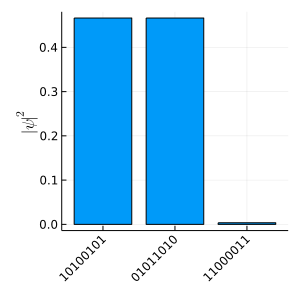

In [49]:
qaoa_10_objective_ratio = max_cut / qaoa_10_objective
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_10.moments)
plot_result(result)

In [50]:
p = 8
ε = 0.5
(initial_γs_8, initial_βs_8) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
(circ_opt_8, qaoa_8_objective, qaoa_8_rounds) = optimize_ws_qaoa(
    to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_8, initial_βs_8))

Training, round 0: average objective = 6.0
Training, round 1: average objective=6.407570615400552
Training, round 2: average objective=6.701390726310021
Training, round 3: average objective=6.969652477465822
Training, round 4: average objective=7.21831110723317
Training, round 5: average objective=7.4481849402598295
Training, round 6: average objective=7.659635606573269
Training, round 7: average objective=7.855037143211743
Training, round 8: average objective=8.039319330401014
Training, round 9: average objective=8.2206434994685
Training, round 10: average objective=8.410517425546326
Training, round 11: average objective=8.616116938418577
Training, round 12: average objective=8.836029789147805
Training, round 13: average objective=9.063432630310036
Training, round 14: average objective=9.289906185362728
Training, round 15: average objective=9.508812995911999
Training, round 16: average objective=9.71665790483154
Training, round 17: average objective=9.911323240570072
Training, round 1

Training, round 145: average objective=11.566703903510193
Training, round 146: average objective=11.568031344343535
Training, round 147: average objective=11.56936306326643
Training, round 148: average objective=11.57069954279873
Training, round 149: average objective=11.572040768086651
Training, round 150: average objective=11.573386715765032
Training, round 151: average objective=11.574737435149371
Training, round 152: average objective=11.576093129256872
Training, round 153: average objective=11.577454104153949
Training, round 154: average objective=11.57882081348015
Training, round 155: average objective=11.580193903083954
Training, round 156: average objective=11.581574001463721
Training, round 157: average objective=11.582961736073724
Training, round 158: average objective=11.584357740987233
Training, round 159: average objective=11.58576263035447
Training, round 160: average objective=11.587176973979425
Training, round 161: average objective=11.58860121457892
Training, round 162

Training, round 287: average objective=11.845839901711553
Training, round 288: average objective=11.84689914394881
Training, round 289: average objective=11.847927907063763
Training, round 290: average objective=11.848926958144123
Training, round 291: average objective=11.84989708183504
Training, round 292: average objective=11.850839014832363
Training, round 293: average objective=11.851753565666481
Training, round 294: average objective=11.85264144662337
Training, round 295: average objective=11.853503458882765
Training, round 296: average objective=11.854340413366886
Training, round 297: average objective=11.855153064281065
Training, round 298: average objective=11.855942111907655
Training, round 299: average objective=11.856708354919414
Training, round 300: average objective=11.857452446374023


(
    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |  

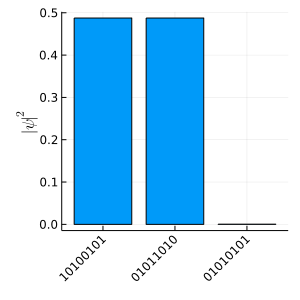

In [51]:
qaoa_8_objective_ratio = max_cut / qaoa_8_objective
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_8.moments)
plot_result(result)

In [95]:
p = 2
ε = 0.5
(initial_γs_2, initial_βs_2) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
(circ_opt_2, qaoa_2_objective, qaoa_2_rounds) = optimize_ws_qaoa(
    to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_2, initial_βs_2))

Training, round 0: average objective = 6.0
Training, round 1: average objective=6.240166126711677
Training, round 2: average objective=6.292337186064236
Training, round 3: average objective=6.351557809056605
Training, round 4: average objective=6.4181836072809055
Training, round 5: average objective=6.492519531639076
Training, round 6: average objective=6.574807509578839
Training, round 7: average objective=6.665210297515538
Training, round 8: average objective=6.763792831943942
Training, round 9: average objective=6.870502244438817
Training, round 10: average objective=6.985147283497611
Training, round 11: average objective=7.107378204957211
Training, round 12: average objective=7.236668348187584
Training, round 13: average objective=7.372298602397888
Training, round 14: average objective=7.513346624368293
Training, round 15: average objective=7.658682697922565
Training, round 16: average objective=7.806973399867248
Training, round 17: average objective=7.956695953959706
Training, rou

(
    8 ——□—————□—————□—————□———
        |     |     |     |   
    7 ——□—————□—————□—————□———
        |     |     |     |   
    6 ——□—————□—————□—————□———
        |     |     |     |   
    5 ——□—————□—————□—————□———
        |     |     |     |   
    4 ——□—————□—————□—————□———
        |     |     |     |   
    3 ——□—————□—————□—————□———
        |     |     |     |   
    2 ——□—————□—————□—————□———
        |     |     |     |   
    1 ——□—————□—————□—————□———
, 9.693108430552655, 83)

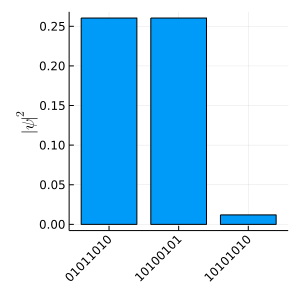

In [96]:
qaoa_2_objective_ratio = max_cut / qaoa_2_objective
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_2.moments)
plot_result(result)

Barely 60% chance that we get the optimal solution. Now let's try to find the optimal cut again in Warm-starting QAOA with less depth:

In [52]:
ws_partitioning = [1.0, 0.0, 1.0, 0.0, 0.0 ,1.0, 0.0, 0.5]
ε = 0.4
init_state_randomized = false
p = 8
rounds = 300
lr = 0.01
(max_cut, max_partition)

(12, ([2, 4, 5, 7], [1, 3, 6, 8]))

In [53]:
(circ_opt_ws_8, ws_qaoa_8_objective, ws_qaoa_8_rounds) = optimize_ws_qaoa(
    to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_8, initial_βs_8))

Training, round 0: average objective = 6.180000000000004
Training, round 1: average objective=6.232907546689349
Training, round 2: average objective=6.420117432798197
Training, round 3: average objective=6.60966612362207
Training, round 4: average objective=6.803166602336936
Training, round 5: average objective=6.996137873194142
Training, round 6: average objective=7.18335748995395
Training, round 7: average objective=7.363438039679869
Training, round 8: average objective=7.536964868332065
Training, round 9: average objective=7.701995899813048
Training, round 10: average objective=7.8547901029639995
Training, round 11: average objective=7.991693374354431
Training, round 12: average objective=8.110181909043412
Training, round 13: average objective=8.209987533066762
Training, round 14: average objective=8.293347633343933
Training, round 15: average objective=8.364113639532974
Training, round 16: average objective=8.426301868817328
Training, round 17: average objective=8.4829500764859
Tra

Training, round 146: average objective=10.612287781139761
Training, round 147: average objective=10.6325507030798
Training, round 148: average objective=10.651984606846192
Training, round 149: average objective=10.670376663096244
Training, round 150: average objective=10.687606450618743
Training, round 151: average objective=10.703640825255704
Training, round 152: average objective=10.71851574888912
Training, round 153: average objective=10.732312016201899
Training, round 154: average objective=10.745131224790429
Training, round 155: average objective=10.757073166430084
Training, round 156: average objective=10.768218280407652
Training, round 157: average objective=10.77861594047651
Training, round 158: average objective=10.78828150991492
Training, round 159: average objective=10.797200810371447
Training, round 160: average objective=10.805343381865354
Training, round 161: average objective=10.812678297660167
Training, round 162: average objective=10.819188985371825
Training, round 163

(
    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |  

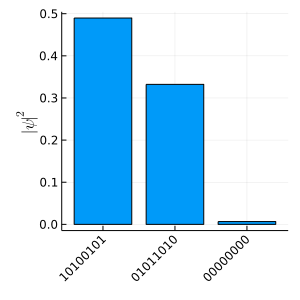

In [54]:
ws_qaoa_8_objective_ratio = max_cut / ws_qaoa_8_objective
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_ws_8.moments)
plot_result(result)

Interestingly, as you see here, the warm-start does not scale well with high depth. If the depth is good enough for the normal QAOA, WS-QAOA should actually at least perform as good as normal QAOA. However, the problem might lie in our gradient calculation. When the warm-starting is used, the derivative of the mixer matrix becomes really complicated, and the gradient calculation (the current method is a single forward difference) is not stable enough to represent that complexity.

However, if we lower the depth furthermore:

In [92]:
p = 2
ε = 0.25
(circ_opt_ws_2, ws_qaoa_2_objective, ws_qaoa_2_rounds) = optimize_ws_qaoa(
    to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 7.124999999999999
Training, round 1: average objective=4.868432206135017
Training, round 2: average objective=4.978986129469034
Training, round 3: average objective=5.104069238065331
Training, round 4: average objective=5.2420584551602705
Training, round 5: average objective=5.391231273145956
Training, round 6: average objective=5.549738418014611
Training, round 7: average objective=5.715593875288891
Training, round 8: average objective=5.886682160182411
Training, round 9: average objective=6.060782935167382
Training, round 10: average objective=6.235613360358924
Training, round 11: average objective=6.408889490955291
Training, round 12: average objective=6.578408058112851
Training, round 13: average objective=6.742149161917303
Training, round 14: average objective=6.898398463354793
Training, round 15: average objective=7.045880055567503
Training, round 16: average objective=7.183878580598064
Training, round 17: average objective=7.312313471854775

Training, round 145: average objective=11.310598842609167
Training, round 146: average objective=11.310897352401422
Training, round 147: average objective=11.311196594743981
Training, round 148: average objective=11.311497501166546
Training, round 149: average objective=11.311800900527075
Training, round 150: average objective=11.312107539484593
Training, round 151: average objective=11.312418111328617
Training, round 152: average objective=11.312733210397814
Training, round 153: average objective=11.313053428414056
No significant improvement, early stopping...


(
    8 ——□—————□—————□—————□———
        |     |     |     |   
    7 ——□—————□—————□—————□———
        |     |     |     |   
    6 ——□—————□—————□—————□———
        |     |     |     |   
    5 ——□—————□—————□—————□———
        |     |     |     |   
    4 ——□—————□—————□—————□———
        |     |     |     |   
    3 ——□—————□—————□—————□———
        |     |     |     |   
    2 ——□—————□—————□—————□———
        |     |     |     |   
    1 ——□—————□—————□—————□———
, 11.313053428414056, 154)

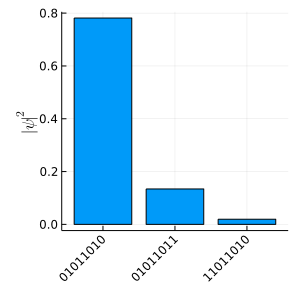

In [93]:
ws_qaoa_2_objective_ratio = max_cut / ws_qaoa_2_objective
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_ws_2.moments,  (initial_γs_2, initial_βs_2))
plot_result(result)

Now we see the real benefit of warm-starting, it can find the solution with high probability even at depth 4, where normal QAOA cannot. Also, as you can see, now the algorithm finds with high probability, only one of the solutions. This is the effect of warm-starting, since the initial state is closer to one of the optimal solutions, our state collapses directly into its closest optimal solution.

It is even possible to further lower the depth, if we switch to recursive WS-QAOA. It might however be a bit unstable sometimes, so you may need to run it again.

In [137]:
p = 1
ε = 0.25
((ws_rqaoa_objective, (p1, p2)), ws_rqaoa_total_rounds_x_qubits) = recursive_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr)
ws_rqaoa_objective_ratio = max_cut / ws_rqaoa_objective
(ws_rqaoa_objective, (p1,p2))

Training, round 0: average objective = 6.749999999999998
Training, round 1: average objective=5.909349354332559
Training, round 2: average objective=5.943285566724649
Training, round 3: average objective=5.9801773743044375
Training, round 4: average objective=6.019985824249795
Training, round 5: average objective=6.062665250033914
Training, round 6: average objective=6.1081593038469215
Training, round 7: average objective=6.156397406381562
Training, round 8: average objective=6.207291523388058
Training, round 9: average objective=6.260733566974559
Training, round 10: average objective=6.316593134812104
Training, round 11: average objective=6.3747155921088545
Training, round 12: average objective=6.4349206460931825
Training, round 13: average objective=6.497001440452132
Training, round 14: average objective=6.560724135926652
Training, round 15: average objective=6.625828097526497
Training, round 16: average objective=6.692027253801672
Training, round 17: average objective=6.759011808946

Training, round 29: average objective=4.826522944400405
Training, round 30: average objective=4.829290596830843
Training, round 31: average objective=4.8319027006430355
Training, round 32: average objective=4.834346040876888
Training, round 33: average objective=4.836605797711579
Training, round 34: average objective=4.838667361737879
Training, round 35: average objective=4.840518063807275
Training, round 36: average objective=4.842148454581338
Training, round 37: average objective=4.843553472262902
Training, round 38: average objective=4.844733292788668
Training, round 39: average objective=4.845693725731072
Training, round 40: average objective=4.84644638007799
Training, round 41: average objective=4.847008289848958
Training, round 42: average objective=4.847401145057797
Training, round 43: average objective=4.8476501405334815
Training, round 44: average objective=4.847782502057576
Training, round 45: average objective=4.847825843461652
Training, round 46: average objective=4.8478065

Training, round 106: average objective=4.150254356313917
Training, round 107: average objective=4.150355494593267
Training, round 108: average objective=4.150442060922428
Training, round 109: average objective=4.150515527461601
Training, round 110: average objective=4.150577341982667
Training, round 111: average objective=4.150628915703721
Training, round 112: average objective=4.150671602098852
Training, round 113: average objective=4.15070667417461
Training, round 114: average objective=4.150735305862078
Training, round 115: average objective=4.150758557712123
Training, round 116: average objective=4.150777365774422
Training, round 117: average objective=4.150792538961684
No significant improvement, early stopping...
Training, round 0: average objective = 1.9999999999999996
Training, round 1: average objective=2.889856446992135
Training, round 2: average objective=2.898698249904757
Training, round 3: average objective=2.906462208708748
Training, round 4: average objective=2.913204381

(12.0, ([5, 2, 7, 4], [1, 3, 8, 6]))

# Overall Convergence vs. Qubits x Parameter x Rounds Comparison

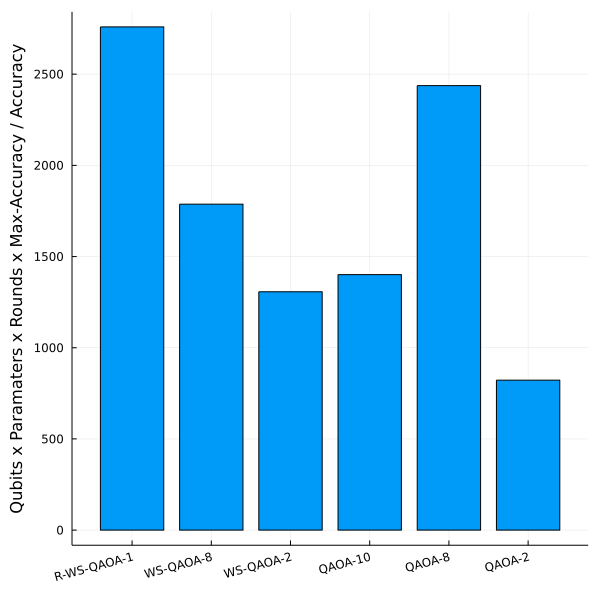

In [140]:
ws_rqaoa_time = ws_rqaoa_total_rounds_x_qubits * ws_rqaoa_objective_ratio
ws_qaoa_8_time = graph.n * ws_qaoa_8_rounds * ws_qaoa_8_objective_ratio
ws_qaoa_2_time = graph.n * ws_qaoa_2_rounds * ws_qaoa_2_objective_ratio
qaoa_10_time = graph.n * qaoa_10_rounds * qaoa_10_objective_ratio
qaoa_8_time = graph.n * qaoa_8_rounds * qaoa_8_objective_ratio
qaoa_2_time = graph.n * qaoa_2_rounds * qaoa_2_objective_ratio

qaoa_times = [ws_rqaoa_time, ws_qaoa_8_time, ws_qaoa_2_time, qaoa_10_time, qaoa_8_time, qaoa_2_time]
tags = ["R-WS-QAOA-1", "WS-QAOA-8", "WS-QAOA-2", "QAOA-10", "QAOA-8", "QAOA-2"]
bar(tags, qaoa_times, xticks=:all, xrotation=15, ylabel="Qubits x Paramaters x Rounds x Max-Accuracy / Accuracy", legend=false, size=(600, 600))

It looks like the recursive warm-start QAOA is faster than some of the other variants. However, in general, this is truly not the case. On a real quantum computer, a measurement is needed to be done for every edge in the graph. To make the simulation faster, this was avoided here.

While the WS-QAOA offers actual speed-up for the convergence, R-WS-QAOA actually offers a trade-off between time and circuit complexity. It can solve bigger-sized problems where the normal methods fail, since the depth cannot be increased after some point.

It is also important to note that even though QAOA-2 has the lowest lowest "time", it did not converge and stopped early. The metrics you see above only makes sense when the methods had reached similar objective function scores. Another way to compare them would be to fix the iterations in the gradient descent.

# WS-QAOA vs. R-WS-QAOA

It turns out, this example cannot be optimally solved with WS-QAOA even at depth 20!

<img src="./img/wsqaoa-neg-pos.png"
     alt="N=8"
     style="float: left; width: 500px" />
     

In [97]:
# Example graph with negative/positive edge weights, shown at: Fig (9)
edges = [
    (1, 2, 3.0), (1, 3, 3.0), (1, 4, 6.0), (1, 5, 9.0), (1, 6, 1.0),
    (2, 3, 4.0), (2, 4, 4.0), (2, 5, -8.0), (2, 6, 4.0),
    (3, 4, 3.0), (3, 5, -7.0), (3, 6, 1.0),
    (4, 5, -7.0), (4, 6, 6.0),
    (5, 6, -5.0)
]
n = 6
graph = EdgeWeightedGraph(n, edges)
ws_partitioning = [0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ε = 0.25
init_state_randomized = true
lr = 0.01
p = 20
rounds = 300

300

In [128]:
p = 20
(circ_opt_fail, _, _) = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 91.25
Training, round 1: average objective=87.97574639361969
Training, round 2: average objective=91.2294089019583
Training, round 3: average objective=92.90830041961844
Training, round 4: average objective=93.36892903973192
Training, round 5: average objective=93.42351912619316
Training, round 6: average objective=94.5566878038019
Training, round 7: average objective=95.15710377235892
Training, round 8: average objective=95.4689199470034
Training, round 9: average objective=95.71287035383459
Training, round 10: average objective=96.65595078762098
Training, round 11: average objective=96.50136592618793
Training, round 12: average objective=96.21651588545649
Training, round 13: average objective=96.38058654090523
Training, round 14: average objective=96.8054438213336
Training, round 15: average objective=97.45110398300729
Training, round 16: average objective=97.54194232799827
Training, round 17: average objective=97.41516126762468
Training, round 

Training, round 145: average objective=100.5753846393322
Training, round 146: average objective=100.57876818363852
Training, round 147: average objective=100.58247010368859
Training, round 148: average objective=100.58653676406513
Training, round 149: average objective=100.5910238917799
Training, round 150: average objective=100.59598757020956
Training, round 151: average objective=100.60149552959342
Training, round 152: average objective=100.6076236949615
Training, round 153: average objective=100.61444296169506
Training, round 154: average objective=100.62202325483359
Training, round 155: average objective=100.63041635680284
Training, round 156: average objective=100.63963617689707
Training, round 157: average objective=100.64965547852333
Training, round 158: average objective=100.66037508400177
Training, round 159: average objective=100.67162230840347
Training, round 160: average objective=100.68316175688017
Training, round 161: average objective=100.69471327785479
Training, round 1

(
    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—

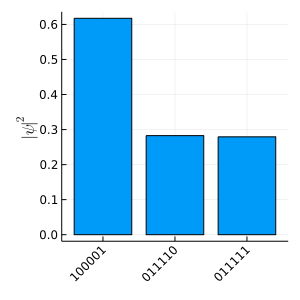

In [255]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_fail.moments)
plot_result(result)

However, using a recursive WS-QAOA with a depth of 5 does the trick:

In [99]:
p = 5
ws_rqaoa_result = recursive_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 6.125000000000001
Training, round 1: average objective=9.754365059996735
Training, round 2: average objective=11.157493295112674
Training, round 3: average objective=11.664664015416946
Training, round 4: average objective=11.672165408685082
Training, round 5: average objective=11.70023265533952
Training, round 6: average objective=11.836337205186972
Training, round 7: average objective=12.064202065644961
Training, round 8: average objective=12.348058737188548
Training, round 9: average objective=12.601721950539154
Training, round 10: average objective=12.758272190687604
Training, round 11: average objective=12.840675484435986
Training, round 12: average objective=12.93039669638964
Training, round 13: average objective=13.0785033333506
Training, round 14: average objective=13.265183392630131
Training, round 15: average objective=13.425592491055763
Training, round 16: average objective=13.50656371511037
Training, round 17: average objective=13.51368

Training, round 54: average objective=38.453329013909034
Training, round 55: average objective=38.39849937710748
Training, round 56: average objective=38.394661933061776
Training, round 57: average objective=38.4511846046757
Training, round 58: average objective=38.53689627406152
Training, round 59: average objective=38.608052062370824
Training, round 60: average objective=38.635291311890356
Training, round 61: average objective=38.619726559356074
Training, round 62: average objective=38.588176900602335
Training, round 63: average objective=38.569817182154075
Training, round 64: average objective=38.578285451011524
Training, round 65: average objective=38.60907797731036
Training, round 66: average objective=38.64364491933901
Training, round 67: average objective=38.66220223448947
Training, round 68: average objective=38.65910662278005
Training, round 69: average objective=38.643518184327874
Training, round 70: average objective=38.628984057013064
Training, round 71: average objective=3

Training, round 72: average objective=42.06789651126124
Training, round 73: average objective=42.072804321259696
Training, round 74: average objective=42.0774620239048
Training, round 75: average objective=42.0819444582055
Training, round 76: average objective=42.086300741414476
Training, round 77: average objective=42.0905162447082
Training, round 78: average objective=42.09454108312883
Training, round 79: average objective=42.09831358222435
Training, round 80: average objective=42.10174069460806
Training, round 81: average objective=42.104695263938744
Training, round 82: average objective=42.107096895497065
Training, round 83: average objective=42.10902217627124
Training, round 84: average objective=42.11071432004262
Training, round 85: average objective=42.112452931201474
Training, round 86: average objective=42.11439280600957
Training, round 87: average objective=42.11650362576371
Training, round 88: average objective=42.11862990970552
Training, round 89: average objective=42.12059

Training, round 102: average objective=6.905349233300482
Training, round 103: average objective=6.907459043986028
Training, round 104: average objective=6.909391236548693
Training, round 105: average objective=6.911140028824676
Training, round 106: average objective=6.9127102864658205
Training, round 107: average objective=6.914116282776867
Training, round 108: average objective=6.915378231625927
Training, round 109: average objective=6.916517627144282
Training, round 110: average objective=6.917552891235051
Training, round 111: average objective=6.918496600775837
Training, round 112: average objective=6.919354793798813
Training, round 113: average objective=6.920128326324616
Training, round 114: average objective=6.920815454783043
Training, round 115: average objective=6.9214146854845895
Training, round 116: average objective=6.9219271717141915
Training, round 117: average objective=6.9223578711257545
Training, round 118: average objective=6.922715443310869
Training, round 119: averag

((27.0, ([1, 6], [2, 3, 4, 5])), 2161)

 # Goemans-Williamson (Best known classical randomized solver) vs R-WS-QAOA
 
 We are now going to try to improve the solution of the GW-Algorithm in a fully connected graph of 8 nodes. It is important to note that this example is as minimal as it gets. For a graph size below 8, GW-Algorithm almost always finds the optimal solution. It also usually manages to produce the correct cut for the example below, but for demonstration purposes we've chosen a run, where it could not, and tried to improve it with R-WS-QAOA.
 
 If your machine is powerful enough, you could also try this with much bigger graphs, where the result would be more meaningful. For the reference, this example was run on a Intel Core i7-7700 HQ machine with Nvidia GTX 1070 graphics card.

In [126]:
edges = [
    (1, 2, 3.0), (1, 3, 5.0), (1, 4, 3.0), (1, 5, 7.0), (1, 6, 8.0), (1, 7, 1.0), (1, 8, 3.0),
    (2, 3, 14.0), (2, 4, 8.0), (2, 5, 6.0), (2, 6, 4.0), (2, 7, 3.0), (2, 8, 1.0),
    (3, 4, 11.0), (3, 5, 12.0), (3, 6, 5.0), (3, 7, 5.0), (3, 8, 9.0),
    (4, 5, 6.0), (4, 6, 16.0), (4, 7, 8.0), (4, 8, 3.0),
    (5, 6, 7.0), (5, 7, 8.0), (5, 8, 3.0),
    (6, 7, 8.0), (6, 8, 1.0),
    (7, 8, 10.0)
] # max cut size 123: 2,5,6,8 / 1,3,4,7, fully connected graph of 8 nodes
n = 8
graph = EdgeWeightedGraph(n, edges)
ws_partitioning = [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0] # cut size 104, got with GW
ε = 0.25
init_state_randomized = true
p = 5
rounds = 300
lr = 0.1
ws = prepare_init_state(ws_partitioning, ε)
max_cut, max_partition = maxcut(adjacency_matrix(graph), iter=1)

Max iterations reached.


(104, ([2, 3, 5, 6, 8], [1, 4, 7]))

In [127]:
p = 5
rounds = 200
lr = 0.01
init_stddev = 0.00000000000000000001
recursive_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr, init_stddev)

Training, round 0: average objective = 91.25
Training, round 1: average objective=91.24999999999967
Training, round 2: average objective=91.2499999999997
Training, round 3: average objective=92.40766294846817
Training, round 4: average objective=95.23745665082373
Training, round 5: average objective=97.6205551313503
Training, round 6: average objective=99.21164991956721
Training, round 7: average objective=101.4130184093026
Training, round 8: average objective=103.90434729217827
Training, round 9: average objective=105.08938894490628
Training, round 10: average objective=104.96997302603836
Training, round 11: average objective=105.21986185796513
Training, round 12: average objective=105.28393785989257
Training, round 13: average objective=105.05411471194381
Training, round 14: average objective=105.19125639587975
Training, round 15: average objective=105.98709666440402
Training, round 16: average objective=107.18521005361626
Training, round 17: average objective=108.22286140121633
Trai

Training, round 144: average objective=115.1505379072231
Training, round 145: average objective=115.1525241782897
Training, round 146: average objective=115.1543857103681
Training, round 147: average objective=115.15611885987374
Training, round 148: average objective=115.15772046532618
Training, round 149: average objective=115.15918762072545
Training, round 150: average objective=115.16052186682225
Training, round 151: average objective=115.16172848245239
Training, round 152: average objective=115.16281528740723
Training, round 153: average objective=115.1637915437066
Training, round 154: average objective=115.16466667622355
Training, round 155: average objective=115.16545019745988
Training, round 156: average objective=115.16615101166718
Training, round 157: average objective=115.16677748879692
Training, round 158: average objective=115.16733764852576
Training, round 159: average objective=115.16783944657412
Training, round 160: average objective=115.16828968851704
Training, round 16

Training, round 106: average objective=67.07854172005392
Training, round 107: average objective=67.09040755708601
Training, round 108: average objective=67.1015385434306
Training, round 109: average objective=67.11186637438355
Training, round 110: average objective=67.12148916386195
Training, round 111: average objective=67.13056586676501
Training, round 112: average objective=67.13916947387764
Training, round 113: average objective=67.14731439894537
Training, round 114: average objective=67.15509886167109
Training, round 115: average objective=67.162726288771
Training, round 116: average objective=67.17037456288148
Training, round 117: average objective=67.17809799260864
Training, round 118: average objective=67.18583822315867
Training, round 119: average objective=67.19345126337211
Training, round 120: average objective=67.20072428879753
Training, round 121: average objective=67.2074591895084
Training, round 122: average objective=67.21359598489025
Training, round 123: average object

Training, round 71: average objective=83.06956022276717
Training, round 72: average objective=83.10781578691163
Training, round 73: average objective=83.14556602235953
Training, round 74: average objective=83.18341549079648
Training, round 75: average objective=83.22036481468969
Training, round 76: average objective=83.25527854127336
Training, round 77: average objective=83.28772124506307
Training, round 78: average objective=83.3174015703494
Training, round 79: average objective=83.34363349974656
Training, round 80: average objective=83.36585451176643
Training, round 81: average objective=83.38443132057841
Training, round 82: average objective=83.40048233973272
Training, round 83: average objective=83.4147969723602
Training, round 84: average objective=83.42716286939334
Training, round 85: average objective=83.43684110861165
Training, round 86: average objective=83.44348552424238
Training, round 87: average objective=83.44743069670045
Training, round 88: average objective=83.449263217

Training, round 75: average objective=34.239979983757834
Training, round 76: average objective=34.24909718227553
Training, round 77: average objective=34.257925450525676
Training, round 78: average objective=34.2667031503198
Training, round 79: average objective=34.27530852286928
Training, round 80: average objective=34.28281942000409
Training, round 81: average objective=34.289979809508125
Training, round 82: average objective=34.29613916062894
Training, round 83: average objective=34.30204736343511
Training, round 84: average objective=34.30791003087706
Training, round 85: average objective=34.31366763080896
Training, round 86: average objective=34.319830823466624
Training, round 87: average objective=34.32586908703864
Training, round 88: average objective=34.331889634456786
Training, round 89: average objective=34.33767618745543
Training, round 90: average objective=34.343016832575834
Training, round 91: average objective=34.34821174572725
Training, round 92: average objective=34.35

Training, round 24: average objective=5.827817369766759
Training, round 25: average objective=5.879993406428971
Training, round 26: average objective=5.878818441411395
Training, round 27: average objective=5.852689330668856
Training, round 28: average objective=5.825790826395215
Training, round 29: average objective=5.8195719199763
Training, round 30: average objective=5.850320507536283
Training, round 31: average objective=5.922601955369967
Training, round 32: average objective=6.027293422569237
Training, round 33: average objective=6.147722616412867
Training, round 34: average objective=6.268354894487405
Training, round 35: average objective=6.378717511288163
Training, round 36: average objective=6.47176515654596
Training, round 37: average objective=6.542371750044595
Training, round 38: average objective=6.589843422735159
Training, round 39: average objective=6.6211200334615095
Training, round 40: average objective=6.648564637669447
Training, round 41: average objective=6.6826959719

Training, round 176: average objective=9.88200962222224
Training, round 177: average objective=9.883606897830724
Training, round 178: average objective=9.88509340917287
Training, round 179: average objective=9.886481828762873
Training, round 180: average objective=9.887783597282109
Training, round 181: average objective=9.889009013874901
Training, round 182: average objective=9.890167602427395
Training, round 183: average objective=9.891267949425739
Training, round 184: average objective=9.892317670929138
Training, round 185: average objective=9.89332352150073
Training, round 186: average objective=9.894291544511606
Training, round 187: average objective=9.895227030311588
Training, round 188: average objective=9.89613446204453
Training, round 189: average objective=9.897017670221818
Training, round 190: average objective=9.897879925469436
Training, round 191: average objective=9.898723979902076
Training, round 192: average objective=9.899552111133815
Training, round 193: average object

No significant improvement, early stopping...
End of recursion!
graph n: 2, graph edges: Set(Tuple{Set{Int64}, Float64}[(Set([2, 1]), 4.0)])
res: ((4.0, ([1], [2])), 0)
return from recursion
partitions: ([1], [2])
v_out: 2
return from recursion
partitions: ([1, 2], [3])
v_out: 2
return from recursion
partitions: ([1, 3], [4, 2])
v_out: 4
return from recursion
partitions: ([1, 3], [5, 2, 4])
v_out: 4
return from recursion
partitions: ([1, 3, 4], [6, 2, 5])
v_out: 7
return from recursion
partitions: ([1, 3, 4], [6, 2, 5, 7])
v_out: 7


((123.0, ([1, 3, 4, 7], [6, 2, 5, 8])), 5821)